In [1]:
from scipy.integrate import odeint
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.signal import lombscargle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
import itertools
from numpy import *
import seaborn as sns
from sklearn.metrics import accuracy_score
#from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics
import os
from sklearn.metrics import confusion_matrix, precision_score
from sklearn.metrics import precision_score 
from imblearn.metrics import specificity_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
#import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
import warnings

In [2]:
# If run locally true then use the path Curvassinteticas if not run from Manu path.
run_locally = True
dff = []
if run_locally:
    dir = 'obs/AGNs/'
    path = 'obs/AGNs/'
    for i in range(1, 26):
        filename = f"Curvassinteticas/orig{'0' if i < 10 else ''}{i}.dat"
        dff.append(np.loadtxt(filename))
else:
    dir = '/home/anakin/Documents/Tesis/Codigo/AGNs/'
    path = '/home/anakin/Documents/Tesis/Codigo/AGNs/' #path to main directory
    for i in range(1, 26):
        filename = f"/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig{'0' if i < 10 else ''}{i}.dat"
        dff.append(np.loadtxt(filename))

In [3]:
#Function to read the files and separate each AGN and its errors.

def agns(data):
    
    #Read the first column which is the Julian days.
    t = data[:,0]
    
    agn=[] #AGNs
    err_agn=[] #AGNs errors
    star=[] #Calibration Stars
    err_star=[] #Calibration Stars errors
    agn_p=[] #Periodic AGNs
    err_agn_p=[] #Periodic AGNs errors

    for i in range(1, 544, 2):

        if i <  400: 
 
            agns = data[:,i]
            err_agns = data[:,i+1]
            agn.append(agns)
            err_agn.append(err_agns)
            
        elif i > 400 and i < 526:
   
            stars = data[:,i]
            err_stars = data[:,i+1]
            star.append(stars)
            err_star.append(err_stars)
            
        elif i > 526: 

            agn_ps = data[:,i]
            err_agn_ps = data[:,i+1]
            agn_p.append(agn_ps)
            err_agn_p.append(err_agn_ps)
            
    return agn, err_agn, star, err_star, agn_p, err_agn_p, t
                                       
    

In [4]:
#We calibrate the observed fluxes of the AGNs using the calibration stars.

#For this, we choose for each AGN the star that has the magnitude most similar to that of the AGN.


#We use the mean of each star and AGN for comparison. 


#We define a function that calculates the star with mean magnitude most similar to the AGN and then subtracts those magnitudes and this is what we will use to determine

#whether an AGN is variable or not.

def calibration(agn, star, err_agn, err_star):

    rest = []
    
    for i in range(63):

        resta = abs (np.mean(star[i])-np.mean(agn))

        rest.append(resta)
    
        ind_min = np.argmin(rest)

        cal = agn - star[ind_min] #Calibrated magnitude

        err_cal = err_agn + err_star[ind_min]#Error calibrated magnitude 
        
    return cal, err_cal

In [5]:
def extract_features(mag, mag_w_err):
    """
    Extract features from the time series data for use in machine learning models.

    :param mag: Magnitude data array.
    :return: Extracted features.
    """
    features = {
        'mag_mean': np.mean(mag),
        'mag_var': np.var(mag),
        'mag_skew': skew(mag),
        'mag_kurt': kurtosis(mag),
        'mag_w_e_mean': np.mean(mag_w_err),
        'mag_w_e_var': np.var(mag_w_err),
        'mag_w_e_skew': skew(mag_w_err),
        'mag_w_e_kurt': kurtosis(mag_w_err),
    }
    
    return features

In [6]:
def remove_outliers(df, column_names):
    """
    Remove outliers from a pandas DataFrame based on the interquartile range.

    :param df: Pandas DataFrame.
    :param column_names: List of column names to check for outliers.
    :return: DataFrame with outliers removed.
    """
    clean_df = df.copy()
    
    for column in column_names:
        Q1 = clean_df[column].quantile(0.10)
        Q3 = clean_df[column].quantile(0.90)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter out the outliers
        clean_df = clean_df[(clean_df[column] >= lower_bound) & (clean_df[column] <= upper_bound)]
    
    return clean_df

In [7]:
#Create an save the dataframe to a CSV file

def dataframe(df, N, p, star, err_star, c, x): # p is the value of the target variable. 1 for variable AGNs and 0 for non-viarable AGNs
                               # df and star must have the same subindex

    for i in range(N): # N: number of AGNs in the dataset

        agn_a = agns(df)[c]
        agn = agn_a[i]

        err_a = agns(df)[x]
        err_agn = err_a[i]

        #Calculates the calibrated magnitude of the AGN
        mag = calibration(agn, star, err_agn, err_star)[0]
        err_mag = calibration(agn, star, err_agn, err_star)[1]

        rng = np.random.default_rng()
        t = rng.uniform(0, 2, N)

        if t[i] <= 1:

            mag_w_err = mag + err_mag

        else:

            mag_w_err = mag - err_mag

        # Extract features from the time series data
        features = extract_features(mag, mag_w_err)
        
        # Store the features and the target variable
        data_features.append(features)

        if p == 1:
            variability.append(1)
        else:
            variability.append(0)

    return data_features

In [8]:
#First whit the non-variable AGNs

data_features = []
data_features_p = []
variability = []

for i in range(len(dff)):

    dt = dff[i]
    star = agns(dt)[2]
    err_star = agns(dt)[3]
    data_features = dataframe(dt, 200, 0, star, err_star, 0, 1)

    # Convert lists to a DataFrame
    features_df = pd.DataFrame(data_features)
    features_df['Variability'] = variability       

 # Save the DataFrame to a CSV file
#features_df.to_csv('simulated_time_series_data_agns.csv', index=False)

In [9]:
#Then with the variable AGNs

for i in range(len(dff)):

    dt = dff[i]
    star = agns(dt)[2]
    err_star = agns(dt)[3]
    data_features = dataframe(dt, 9, 1, star, err_star, 4, 5)

    # Convert lists to a DataFrame
    features_df = pd.DataFrame(data_features)
    features_df['Variability'] = variability       

 # Save the DataFrame to a CSV file
features_df.to_csv('simulated_time_series_data_agns.csv', index=False)

In [10]:
features_df

,mag_mean,mag_var,mag_skew,mag_kurt,mag_w_e_mean,mag_w_e_var,mag_w_e_skew,mag_w_e_kurt,Variability
0,0.010450,0.000020,-0.233428,-0.543255,0.004450,0.000020,-0.233428,-0.543255,0
1,-0.014100,0.000017,-0.209839,0.418627,-0.008100,0.000017,-0.209839,0.418627,0
2,-0.009125,0.000016,0.335852,-0.078736,-0.003125,0.000016,0.335852,-0.078736,0
3,-0.004100,0.000017,-0.199723,-0.703788,-0.010100,0.000017,-0.199723,-0.703788,0
4,0.000325,0.000013,-0.097803,-0.743768,-0.005675,0.000013,-0.097803,-0.743768,0
...,...,...,...,...,...,...,...,...,...
5220,0.013825,0.006252,-0.131830,-1.091343,-0.002375,0.006280,-0.118861,-1.075591,1
5221,-0.012100,0.004425,-0.281331,-1.361673,-0.028300,0.004399,-0.264609,-1.367214,1
5222,0.011225,0.001518,-0.197547,0.424307,0.026825,0.001507,-0.204807,0.346040,1
5223,-0.015050,0.001099,-0.067906,-1.155384,-0.030650,0.001103,-0.060833,-1.125633,1


In [11]:
features_df.isna().sum()

mag_mean        0
mag_var         0
mag_skew        0
mag_kurt        0
mag_w_e_mean    0
mag_w_e_var     0
mag_w_e_skew    0
mag_w_e_kurt    0
Variability     0
dtype: int64

In [12]:
features_df.fillna(0, inplace=True)
features_df.dropna(inplace=True)

In [13]:
features_df.corr()

,mag_mean,mag_var,mag_skew,mag_kurt,mag_w_e_mean,mag_w_e_var,mag_w_e_skew,mag_w_e_kurt,Variability
mag_mean,1.000000,-0.041650,0.026497,0.028460,0.912950,-0.037718,0.035683,0.036083,-0.100698
mag_var,-0.041650,1.000000,-0.059936,-0.158785,-0.039884,0.998902,-0.052041,-0.159265,0.756343
mag_skew,0.026497,-0.059936,1.000000,0.043838,0.028986,-0.061224,0.808046,0.038896,-0.094039
mag_kurt,0.028460,-0.158785,0.043838,1.000000,0.019271,-0.150991,0.022822,0.892988,-0.218651
mag_w_e_mean,0.912950,-0.039884,0.028986,0.019271,1.000000,-0.037675,0.187494,0.028183,-0.091886
mag_w_e_var,-0.037718,0.998902,-0.061224,-0.150991,-0.037675,1.000000,-0.053927,-0.151783,0.751576
mag_w_e_skew,0.035683,-0.052041,0.808046,0.022822,0.187494,-0.053927,1.000000,0.028370,-0.085703
mag_w_e_kurt,0.036083,-0.159265,0.038896,0.892988,0.028183,-0.151783,0.028370,1.000000,-0.217122
Variability,-0.100698,0.756343,-0.094039,-0.218651,-0.091886,0.751576,-0.085703,-0.217122,1.000000


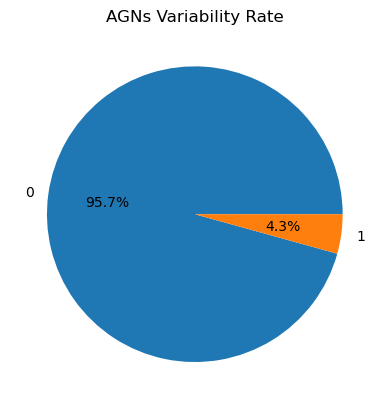

In [14]:
pie_x, pie_y = np.unique(features_df['Variability'], return_counts=True)
plt.pie(pie_y, labels=pie_x, autopct = '%1.1f%%') 
plt.title('AGNs Variability Rate')
plt.show()

# Pycaret AutoML

In [15]:
features_df.columns

Index(['mag_mean', 'mag_var', 'mag_skew', 'mag_kurt', 'mag_w_e_mean',
       'mag_w_e_var', 'mag_w_e_skew', 'mag_w_e_kurt', 'Variability'],
      dtype='object')

In [37]:
# import pycaret for clasiification, the dataset is features_df and the target variable is Variability is very desbalanced
# we will use the SMOTE method to balance the dataset.
import pycaret
from pycaret.classification import *

# Setup the classification model
clf1 = setup(data=features_df[['mag_mean', 'mag_var', 'mag_skew', 'mag_kurt','Variability']], target='Variability',fix_imbalance=True)


,Description,Value
0,Session id,8948
1,Target,Variability
2,Target type,Binary
3,Original data shape,"(5225, 5)"
4,Transformed data shape,"(8568, 5)"
5,Transformed train set shape,"(7000, 5)"
6,Transformed test set shape,"(1568, 5)"
7,Numeric features,4
8,Preprocess,True
9,Imputation type,simple


In [38]:
# Compare the performance of different classification models
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.9934,0.9726,0.8467,1.0000,0.9139,0.9106,0.9156,0.0090
et,Extra Trees Classifier,0.9934,0.9983,0.9292,0.9252,0.9253,0.9219,0.9229,0.0390
lightgbm,Light Gradient Boosting Machine,0.9934,0.9933,0.9292,0.9230,0.9247,0.9212,0.9220,0.4430
rf,Random Forest Classifier,0.9923,0.9953,0.9550,0.8864,0.9172,0.9132,0.9151,0.0590
ada,Ada Boost Classifier,0.9915,0.9977,0.9488,0.8748,0.9083,0.9039,0.9058,0.0290
dt,Decision Tree Classifier,0.9912,0.9646,0.9354,0.8810,0.9038,0.8992,0.9016,0.0080
gbc,Gradient Boosting Classifier,0.9902,0.9968,0.9483,0.8562,0.8957,0.8906,0.8942,0.0750
nb,Naive Bayes,0.9839,0.9897,0.9296,0.7618,0.8339,0.8256,0.8320,0.0940
qda,Quadratic Discriminant Analysis,0.9789,0.9882,0.9488,0.6980,0.7990,0.7884,0.8016,0.0070
dummy,Dummy Classifier,0.9571,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0100


In [40]:
best_model

LinearDiscriminantAnalysis(covariance_estimator=None, n_components=None,
                           priors=None, shrinkage=None, solver='svd',
                           store_covariance=False, tol=0.0001)

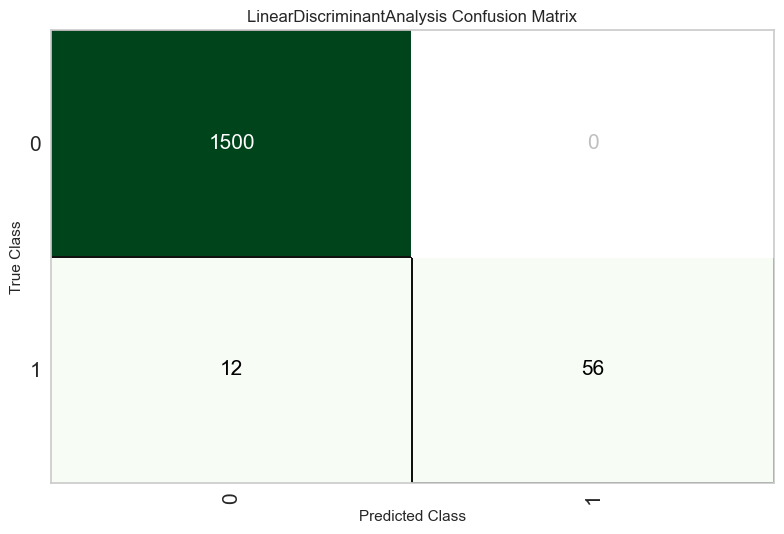

In [41]:
# plot confusion matrix
plot_model(best_model, plot = 'confusion_matrix')

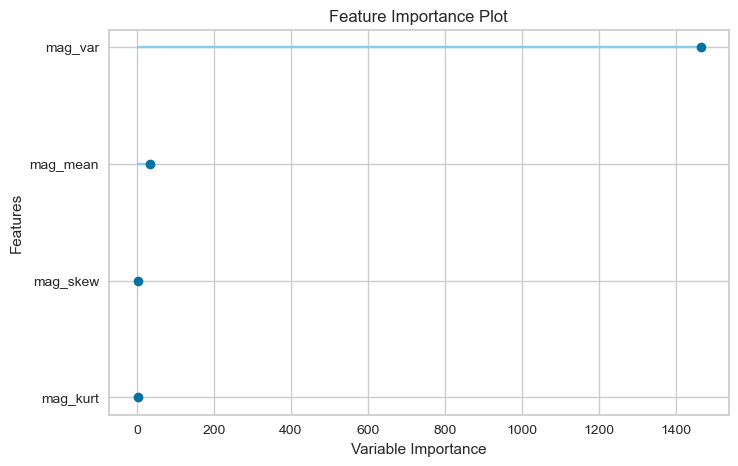

In [42]:
# plot feature importance
plot_model(best_model, plot = 'feature')

In [43]:
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [44]:
# predict on test set
holdout_pred = predict_model(best_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Linear Discriminant Analysis,0.9923,0.9872,0.8235,1.0000,0.9032,0.8993,0.9039


In [45]:
# save the model in a variable to use for prediction
final_best_model = finalize_model(best_model)

In [46]:
# show predictions df
holdout_pred.head()

,mag_mean,mag_var,mag_skew,mag_kurt,Variability,prediction_label,prediction_score
1112,-0.00085,0.000032,0.202552,-0.075846,0,0,0.9545
3167,0.00860,0.000277,0.236115,0.064842,0,0,0.9648
152,-0.00810,0.000046,0.428128,-0.420188,0,0,0.9304
3134,-0.01235,0.000123,0.577514,-0.699722,0,0,0.8934
4337,0.00505,0.000399,-0.861265,0.866624,0,0,0.9163


In [47]:
def calibration1(agn, star):

    rest = []
    
    for i in range(5):

        resta = abs (np.mean(star[i])-np.mean(agn))

        rest.append(resta)
    
        ind_min = np.argmin(rest)

        cal = agn - star[ind_min] #Calibrated magnitude
            
    return cal

In [48]:
def subsample_time_series(mag, t, subsample_size=30):
    """
    Subsample the time series data to simulate incomplete observations.

    :param t: AGN magnitudes
    :param subsample_size: The number of data points to subsample to.
    :return: Subsampled time series data mag.
    """
    # Ensure we always subsample the same way for reproducibility
    np.random.seed(0)
    
    # Choose random indices for subsampling
    subsample_indices = np.random.choice(len(t), size=subsample_size, replace=False)
    subsample_indices.sort()  # Sort the indices to maintain the time order
    
    return mag[subsample_indices], t[subsample_indices]

In [49]:
def extract_features_obs(mag,n, mag_w_err):
    """
    Extract features from the time series data for use in machine learning models.

    :param mag: Magnitude data array.
    :return: Extracted features.
    """
    features = {
        'mag_mean': np.mean(mag),
        'mag_var': np.var(mag),
        'mag_skew': skew(mag),
        'mag_kurt': kurtosis(mag),
    }

    err_features = {
        'err_mean_m': np.mean(mag)/n,
        'err_var_m': np.var(mag)/n,
        'err_skew_m': skew(mag)/n,
        'err_kurt_m': skew(mag)/n,
    }

    features_w_e = {
        'mag_w_e_mean': np.mean(mag),
        'mag_w_e_var': np.var(mag),
        'mag_w_e_skew': skew(mag),
        'mag_w_e_kurt': kurtosis(mag),
    }
    
    return features, features_w_e, err_features

In [50]:
#Create a dataframe for the observations an save it to a CSV file

def dataframe_obs(df): 
    
    D1 = df['D1'] #Diference between AGN and calibration star magnitudes
    err_D1 = df['eD1'] #error of the diference between AGN and calibration star magnitudes
    D2 = df['D2'] #Diference between AGN and control star magnitudes
    err_D2 = df['eD2'] #error of the diference between AGN and calibration star magnitudes

    #Calculates the Diference between D1 and D2
    mag = abs(D1-D2)
    err_obs = err_D1 + err_D2
    n = len(mag)

    rng = np.random.default_rng()
    t = rng.uniform(0, 2, 100)

    if t.any() <= 1:

        mag_w_err = mag + err_obs

    else:

        mag_w_err = mag - err_obs
        
    # Subsample the time series data to simulate incomplete observations
    #mag_subsampled = subsample_time_series(mag, t, subsample_size)        
    
    # Extract features from the time series data
    features_obs = extract_features_obs(mag, n, mag_w_err)[0]
    err_features_obs = extract_features_obs(mag, n, mag_w_err)[1]
    
    return features_obs, err_features_obs

In [29]:
dir

'obs/AGNs/'

In [51]:
#List all the AGNs, each one is a directory
names_agns = os.listdir(dir)
names_agns 

['agn_0847',
 'agn_1958',
 'agn_2126',
 'agn_1443',
 'agn_0208',
 'agn_1917',
 'agn_2310',
 'agn_0414',
 'agn_2149',
 'agn_1229',
 'agn_2005',
 'agn_1424',
 'agn_1256',
 'agn_0521',
 'agn_1510',
 'agn_1127',
 'agn_1116',
 'agn_2155']

In [31]:
len(names_agns)

18

In [53]:
#we go through all the subdirectories corresponding to each AGN and in each one all the files with different observations and we make a classification for each observation.
filelist = os.listdir(path)
df_obs = []
names1 = []
observations = []
k=0
#Make empty list to store all paths to subdirectories in.
path2 = []
for x in filelist:
    if x.startswith('agn'):
        path2.append(path + x+ '/')

for i in path2:
    filelist2 = os.listdir(i)
    c=0
    p=0
    for j in filelist2:
        print(j)
        if j.endswith('.csv'):
            print(i+j)
            file = pd.read_csv(i+j, dtype=np.float64, na_values='INDEF')
            print(file)
            long= len(file['D1'])
            print(long)

            data_features_obs = []

            features_obs = dataframe_obs(file)[0]
            
            # Store the features 
            data_features_obs.append(features_obs)    
                
            # Convert lists to a DataFrame
            features_df_var = pd.DataFrame(data_features_obs)

            # Predict with the best model 
            predicted = predict_model(final_best_model, data=features_df_var)
    
            print(j, ':Classified', predicted, 'with', long, 'observations')

            c+=1
            if predicted == 1:
                
                df_obs.append(features_obs)
                names1.append(j)
                observations.append(long)

                p+=1
                
    prob = p/c*100

    print('-------------------------------------------------',names_agns[k], 'is variable whit a probability of:', prob, '%')
    k+=1

# Convert lists to a DataFrame
df_obs = pd.DataFrame(df_obs)
df_obs['AGN_n_obs'] = names1
df_obs['Observations'] = observations

0847R-220414.csv
obs/AGNs/agn_0847/0847R-220414.csv
      dHJD     D1    eD1     D2    eD2
0   0.5011  0.431  0.004  0.796  0.004
1   0.5104  0.422  0.004  0.793  0.004
2   0.5203  0.435  0.004  0.797  0.004
3   0.5307  0.441  0.004  0.797  0.004
4   0.5410  0.436  0.004  0.793  0.004
5   0.5519  0.425  0.003  0.788  0.004
6   0.5629  0.428  0.004  0.781  0.004
7   0.5739  0.441  0.004  0.787  0.004
8   0.5852  0.429  0.004  0.777  0.004
9   0.5971  0.432  0.004  0.772  0.004
10  0.6093  0.428  0.004  0.776  0.004
11  0.6209  0.430  0.004  0.778  0.004
12


0847R-220414.csv :Classified    mag_mean   mag_var  mag_skew  mag_kurt  prediction_label  prediction_score
0   0.35475  0.000078    0.1852 -0.952915                 0               1.0 with 12 observations


ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [35]:
features_df_var

,mag_w_e_mean,mag_w_e_var,mag_w_e_skew,mag_w_e_kurt
0,0.35475,0.000078,0.1852,-0.952915


In [35]:
path2

['obs/AGNs/agn_0847/',
 'obs/AGNs/agn_1958/',
 'obs/AGNs/agn_2126/',
 'obs/AGNs/agn_1443/',
 'obs/AGNs/agn_0208/',
 'obs/AGNs/agn_1917/',
 'obs/AGNs/agn_2310/',
 'obs/AGNs/agn_0414/',
 'obs/AGNs/agn_2149/',
 'obs/AGNs/agn_1229/',
 'obs/AGNs/agn_2005/',
 'obs/AGNs/agn_1424/',
 'obs/AGNs/agn_1256/',
 'obs/AGNs/agn_0521/',
 'obs/AGNs/agn_1510/',
 'obs/AGNs/agn_1127/',
 'obs/AGNs/agn_1116/',
 'obs/AGNs/agn_2155/']

In [54]:
#we go through all the subdirectories corresponding to each AGN and in each one all the files with different observations and we make a classification for each observation.

#path = '/home/anakin/Documents/Tesis/Codigo/AGNs/' #path to main directory
filelist = os.listdir(path)
df_obs_err = []
names1 = []
observations = []
k=0
#Make empty list to store all paths to subdirectories in.
path2 = []
for x in filelist:
    if x.startswith('agn'):
        path2.append(path + x+ '/')

for i in path2:
    filelist2 = os.listdir(i)
    c=0
    p=0
    for j in filelist2:
        if j.endswith('.csv'):
            file = pd.read_csv(i+j, dtype=np.float64, na_values='INDEF')
            long= len(file['D1'])

            err_features_obs = []

            features_obs = dataframe_obs(file)[1]
            
            # Store the features 
            err_features_obs.append(features_obs)    
                
            # Convert lists to a DataFrame
            features_df_var = pd.DataFrame(err_features_obs)

            # Predict with the model
            predicted = rf_classifier0.predict(features_df_var)
    
            print(j, ':Classified', predicted, 'with', long, 'observations')

            c+=1
            if predicted == 1:
                
                df_obs_err.append(features_obs)
                names1.append(j)
                observations.append(long)

                p+=1
                
    prob = p/c*100

    print('-------------------------------------------------',names_agns[k], 'is variable whit a probability of:', prob, '%')
    k+=1

# Convert lists to a DataFrame
df_obs_err = pd.DataFrame(df_obs_err)
df_obs_err['AGN_n_obs'] = names1
df_obs_err['Observations'] = observations

NameError: name 'rf_classifier0' is not defined

#### As we can see, this dataset is very unbalanced.

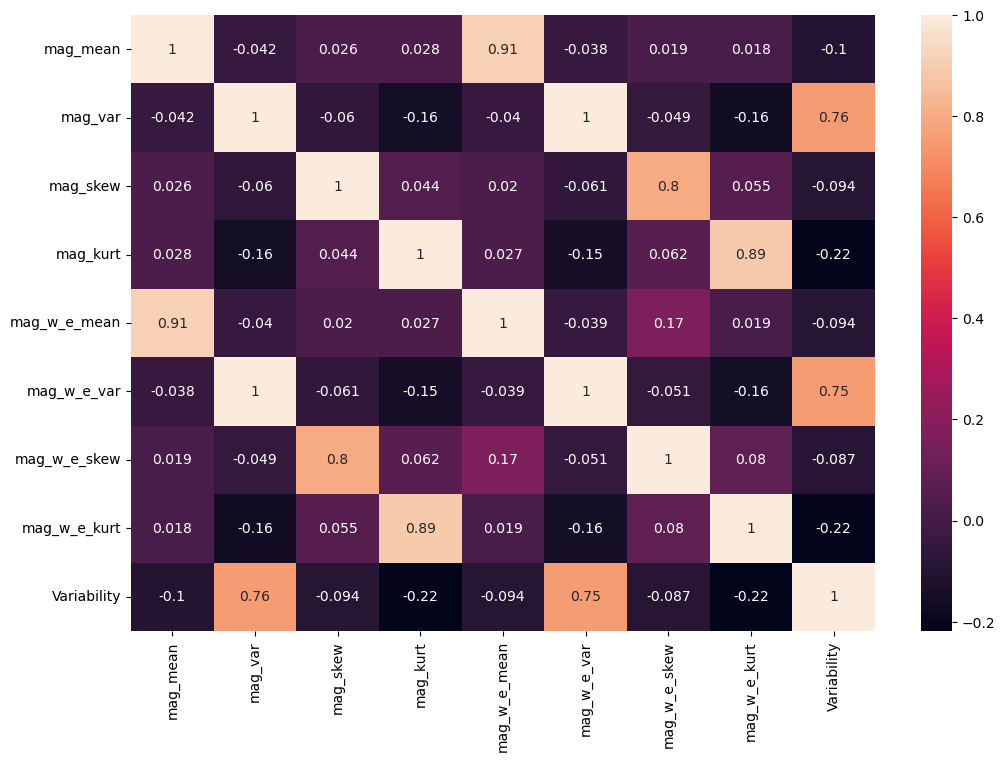

In [24]:
#Perform a correlation matrix to see how the data are related.

plt.figure(figsize=(12,8))
sns.heatmap(features_df.corr(), annot=True)
plt.show()

In [25]:
features_df.Variability.value_counts()

0    5000
1     225
Name: Variability, dtype: int64

In [26]:
df_0 = features_df[features_df['Variability'] == 0 ].sample(n=500)

In [27]:
df_0

,mag_mean,mag_var,mag_skew,mag_kurt,mag_w_e_mean,mag_w_e_var,mag_w_e_skew,mag_w_e_kurt,Variability
2628,0.000850,0.000020,0.198916,-0.204437,-0.006775,0.000023,0.049349,-0.388815,0
2140,-0.010800,0.000073,0.952228,0.809315,-0.023375,0.000077,0.572652,-0.279867,0
492,-0.009075,0.000027,0.122918,-0.178779,-0.001075,0.000027,0.122918,-0.178779,0
522,-0.009525,0.000035,0.236133,-0.336759,-0.017600,0.000034,0.274084,-0.299931,0
947,-0.007525,0.000071,-0.352796,-0.039839,0.002475,0.000071,-0.352796,-0.039839,0
...,...,...,...,...,...,...,...,...,...
3068,-0.010425,0.000120,0.172355,0.304033,-0.024275,0.000121,0.154109,0.270379,0
2642,0.011525,0.000045,0.589953,1.102784,0.019475,0.000051,1.046240,2.413489,0
1216,-0.001725,0.000019,-0.107712,-0.586621,-0.007725,0.000019,-0.107712,-0.586621,0
4653,0.004475,0.000114,-0.151807,-0.698715,-0.012275,0.000135,-0.417601,-0.356084,0


In [28]:
df_1 =  features_df[features_df['Variability'] == 1 ].sample(n=225)

In [29]:
df_1

,mag_mean,mag_var,mag_skew,mag_kurt,mag_w_e_mean,mag_w_e_var,mag_w_e_skew,mag_w_e_kurt,Variability
5105,-0.006775,0.002321,-0.594593,-0.984823,0.002700,0.002215,-0.618755,-0.985556,1
5103,-0.012275,0.008541,0.175204,-1.398562,-0.021950,0.008557,0.184176,-1.400998,1
5115,0.000225,0.000841,-0.107100,-1.330637,0.009125,0.000841,-0.081831,-1.325206,1
5001,-0.011600,0.003450,0.054997,-1.173883,-0.017600,0.003450,0.054997,-1.173883,1
5209,-0.008275,0.002094,-0.740583,-0.435062,-0.022075,0.002057,-0.752409,-0.466655,1
...,...,...,...,...,...,...,...,...,...
5048,-0.006975,0.000952,-0.602181,-0.987928,-0.012975,0.000952,-0.602181,-0.987928,1
5201,-0.008150,0.000838,-0.465929,-1.004655,-0.022875,0.000847,-0.426608,-1.057327,1
5066,-0.005300,0.000946,-0.543974,-1.099840,-0.011300,0.000946,-0.543974,-1.099840,1
5096,0.014275,0.002421,-0.286918,-1.515239,0.024100,0.002383,-0.266091,-1.532118,1


In [30]:
df = pd.concat([df_0, df_1])

In [31]:
df.index =  range(df.shape[0])

In [32]:
df

,mag_mean,mag_var,mag_skew,mag_kurt,mag_w_e_mean,mag_w_e_var,mag_w_e_skew,mag_w_e_kurt,Variability
0,0.000850,0.000020,0.198916,-0.204437,-0.006775,0.000023,0.049349,-0.388815,0
1,-0.010800,0.000073,0.952228,0.809315,-0.023375,0.000077,0.572652,-0.279867,0
2,-0.009075,0.000027,0.122918,-0.178779,-0.001075,0.000027,0.122918,-0.178779,0
3,-0.009525,0.000035,0.236133,-0.336759,-0.017600,0.000034,0.274084,-0.299931,0
4,-0.007525,0.000071,-0.352796,-0.039839,0.002475,0.000071,-0.352796,-0.039839,0
...,...,...,...,...,...,...,...,...,...
720,-0.006975,0.000952,-0.602181,-0.987928,-0.012975,0.000952,-0.602181,-0.987928,1
721,-0.008150,0.000838,-0.465929,-1.004655,-0.022875,0.000847,-0.426608,-1.057327,1
722,-0.005300,0.000946,-0.543974,-1.099840,-0.011300,0.000946,-0.543974,-1.099840,1
723,0.014275,0.002421,-0.286918,-1.515239,0.024100,0.002383,-0.266091,-1.532118,1


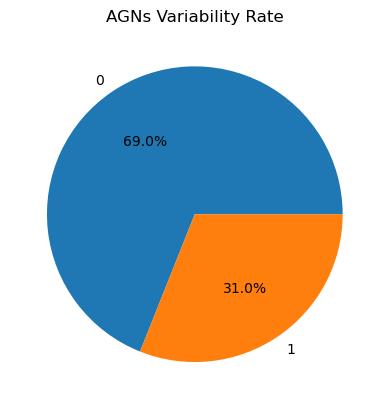

In [33]:
pie_x, pie_y = np.unique(df['Variability'], return_counts=True)
plt.pie(pie_y, labels=pie_x, autopct = '%1.1f%%') 
plt.title('AGNs Variability Rate')
plt.show()

### Machine Learning models

In [578]:
#Apply a Machine Learning model, a Logistic Regression.

data1 = features_df.copy()

X = data1.drop('Variability', axis=1)[['mag_mean', 'mag_var', 'mag_skew', 'mag_kurt']]
y = data1['Variability']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20, stratify = y)

# Initialize the Random Forest Classifier
clf = LogisticRegression(random_state=0)

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
r2_score(y_pred, y_test)

-1.6738798071268954

We'll try to improve the model.

In [579]:
#Apply a Random Forest classifier with the original dataset.

data = features_df.copy()

# Split the data into features and target
X = data.drop('Variability', axis=1)[['mag_mean', 'mag_var', 'mag_skew', 'mag_kurt']]
y = data['Variability']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20, stratify = y)

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(max_depth=10)

# Train the model
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy_score(y_pred,y_test)

0.9968112244897959

In [580]:
#Another Machine Learning model, a Random Forest classifier with an UnderSampling.

# Split the data into features and target
X = df.drop('Variability', axis=1)[['mag_mean', 'mag_var', 'mag_skew', 'mag_kurt']]
y = df['Variability']

# Split the dataset into training and testing sets
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y, test_size=0.2, random_state=20, stratify = y)

# Initialize the Random Forest Classifier
rf_classifier1 = RandomForestClassifier(max_depth=10)

# Train the model
rf_classifier1.fit(X1_train, y1_train)

# Make predictions on the test set
y1_pred = rf_classifier1.predict(X1_test)

# Evaluate the model
accuracy_score(y1_pred,y1_test)

0.9793103448275862

In [581]:
#Another Machine Learning model, a Random Forest classifier with an OverSampling.

data_1 = features_df.copy()

# Split the data into features and target
X = data_1.drop('Variability', axis=1)[['mag_mean', 'mag_var', 'mag_skew', 'mag_kurt']]
y = data_1['Variability']

ros = RandomOverSampler(random_state=20, sampling_strategy='minority')

X_res, y_res = ros.fit_resample(X, y)

# Split the dataset into training and testing sets
X11_train, X11_test, y11_train, y11_test = train_test_split(X_res, y_res, test_size=0.3, random_state=20, stratify = y_res)

# Initialize the Random Forest Classifier
rf_classifier11 = RandomForestClassifier(max_depth=10)

# Train the model
rf_classifier11.fit(X11_train, y11_train)

# Make predictions on the test set
y11_pred = rf_classifier11.predict(X11_test)

# Evaluate the model
accuracy_score(y11_pred,y11_test)

0.9963333333333333

#### We use the metrics to evaluate the model

Metrics of first Random Forest Model

In [582]:
confusion = metrics.confusion_matrix(y_test, y_pred)
confusion.ravel()

array([1500,    0,    5,   63])

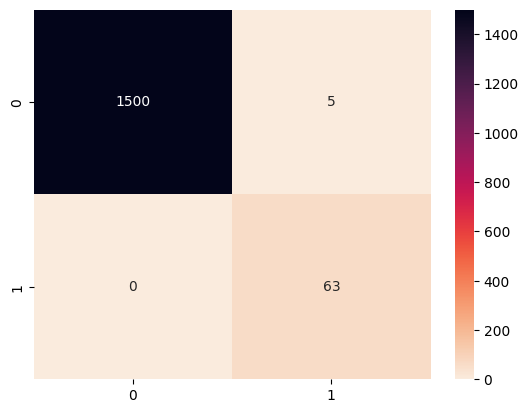

In [583]:
mc=confusion_matrix(y_pred,y_test)
mc_norm = mc / np.linalg.norm(mc, axis=1, keepdims=True)
sns.heatmap(pd.DataFrame(mc), cmap=sns.cm.rocket_r, annot=True, fmt='.5g');

In [584]:
cross_val_score(rf_classifier,X_train,y_train,cv=3,scoring='precision').mean()

1.0

In [585]:
cross_val_score(rf_classifier,X_train,y_train,cv=3,scoring='recall').mean()

0.8858248669569425

In [586]:
cross_val_score(rf_classifier,X_train,y_train,cv=3,scoring='f1').mean()

0.942330031669025

Metrics of model with UnderSampling

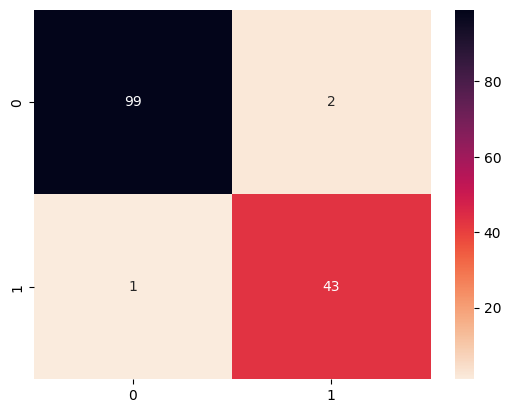

In [587]:
mc=confusion_matrix(y1_pred,y1_test)
mc_norm = mc / np.linalg.norm(mc, axis=1, keepdims=True)
sns.heatmap(pd.DataFrame(mc), cmap=sns.cm.rocket_r, annot=True, fmt='.5g');

In [588]:
cross_val_score(rf_classifier1,X1_train,y1_train,cv=3,scoring='precision').mean()

0.9834213207372419

In [589]:
cross_val_score(rf_classifier1,X1_train,y1_train,cv=3,scoring='recall').mean()

0.9666666666666667

In [590]:
cross_val_score(rf_classifier1,X1_train,y1_train,cv=3,scoring='f1').mean()

0.9747863846477097

Metrics of model with OverSampling

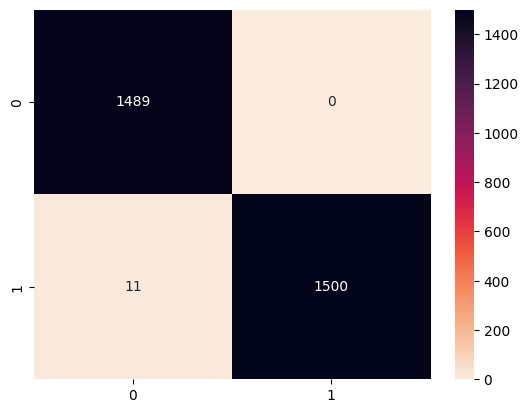

In [591]:
mc=confusion_matrix(y11_pred,y11_test)
mc_norm = mc / np.linalg.norm(mc, axis=1, keepdims=True)
sns.heatmap(pd.DataFrame(mc), cmap=sns.cm.rocket_r, annot=True, fmt='.5g');

In [592]:
cross_val_score(rf_classifier11,X11_train,y11_train,cv=3,scoring='precision').mean()

0.994612992322916

In [593]:
cross_val_score(rf_classifier11,X11_train,y11_train,cv=3,scoring='recall').mean()

1.0

In [594]:
cross_val_score(rf_classifier11,X11_train,y11_train,cv=3,scoring='f1').mean()

0.9971522092158845

#### The second Random Forest model its better, so we will use this one.

In [595]:
#Precision score
precision_score(y1_pred, y1_test)

0.9555555555555556

In [596]:
#Specificity score
specificity_score(y1_pred,y1_test)

0.9801980198019802

In [597]:
#ROC AUC score
roc_auc_score(y1_pred,y1_test)

0.9787353735373537

In [598]:
#Recall score
recall_score(y1_test, y1_pred) 

0.9555555555555556

In [599]:
#F1 score
f1_score(y1_test, y1_pred) 

0.9662921348314608

In [600]:
print(classification_report(y1_test,y1_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       100
           1       0.98      0.96      0.97        45

    accuracy                           0.98       145
   macro avg       0.98      0.97      0.98       145
weighted avg       0.98      0.98      0.98       145



grid search

### Now we'll use real observations of some AGNs to classify them.  

In [50]:
#Function to read the observations and separate each AGN and calibration Stars.

def agns1(data):
    
    #Read the first column which is the Julian days.
    t = data[:,0]
    
    agn=data[:,1] #AGN magnitude
    cal_star=[] #Calibration Stars
    
    for i in range(2, 9, 1):

        if i != 6 and i != 8:

            stars = data[:,i]
            cal_star.append(stars)

    return agn, cal_star, t

In [51]:
def calibration1(agn, star):

    rest = []
    
    for i in range(5):

        resta = abs (np.mean(star[i])-np.mean(agn))

        rest.append(resta)
    
        ind_min = np.argmin(rest)

        cal = agn - star[ind_min] #Calibrated magnitude
            
    return cal

In [52]:
def subsample_time_series(mag, t, subsample_size=30):
    """
    Subsample the time series data to simulate incomplete observations.

    :param t: AGN magnitudes
    :param subsample_size: The number of data points to subsample to.
    :return: Subsampled time series data mag.
    """
    # Ensure we always subsample the same way for reproducibility
    np.random.seed(0)
    
    # Choose random indices for subsampling
    subsample_indices = np.random.choice(len(t), size=subsample_size, replace=False)
    subsample_indices.sort()  # Sort the indices to maintain the time order
    
    return mag[subsample_indices], t[subsample_indices]

In [53]:
def extract_features_obs(mag,n, mag_w_err):
    """
    Extract features from the time series data for use in machine learning models.

    :param mag: Magnitude data array.
    :return: Extracted features.
    """
    features = {
        'mag_mean': np.mean(mag),
        'mag_var': np.var(mag),
        'mag_skew': skew(mag),
        'mag_kurt': kurtosis(mag),
    }

    err_features = {
        'err_mean_m': np.mean(mag)/n,
        'err_var_m': np.var(mag)/n,
        'err_skew_m': skew(mag)/n,
        'err_kurt_m': skew(mag)/n,
    }

    features_w_e = {
        'mag_w_e_mean': np.mean(mag),
        'mag_w_e_var': np.var(mag),
        'mag_w_e_skew': skew(mag),
        'mag_w_e_kurt': kurtosis(mag),
    }
    
    return features, features_w_e, err_features

In [54]:
#Create a dataframe for the observations an save it to a CSV file

def dataframe_obs(df): 
    
    D1 = df['D1'] #Diference between AGN and calibration star magnitudes
    err_D1 = df['eD1'] #error of the diference between AGN and calibration star magnitudes
    D2 = df['D2'] #Diference between AGN and control star magnitudes
    err_D2 = df['eD2'] #error of the diference between AGN and calibration star magnitudes

    #Calculates the Diference between D1 and D2
    mag = abs(D1-D2)
    err_obs = err_D1 + err_D2
    n = len(mag)

    rng = np.random.default_rng()
    t = rng.uniform(0, 2, 100)

    if t.any() <= 1:

        mag_w_err = mag + err_obs

    else:

        mag_w_err = mag - err_obs
        
    # Subsample the time series data to simulate incomplete observations
    #mag_subsampled = subsample_time_series(mag, t, subsample_size)        
    
    # Extract features from the time series data
    features_obs = extract_features_obs(mag, n, mag_w_err)[0]
    err_features_obs = extract_features_obs(mag, n, mag_w_err)[1]
    
    return features_obs, err_features_obs

In [57]:
#List all the AGNs, each one is a directory
names_agns = os.listdir(dir)
names_agns 

['agn_2341',
 'agn_2347',
 'agn_2340',
 'agn_1933',
 'agn_1101',
 'agn_1334',
 'agn_1622',
 'agn_0537',
 'agn_1606',
 'agn_2022',
 'agn_1034',
 'agn_0208',
 'agn_3c273',
 'agn_1125',
 'agn_0637',
 'agn_2316',
 'agn_1331',
 'agn_2320',
 'agn_1157',
 'agn_2344',
 'agn_2200',
 'agn_1229',
 'agn_2254',
 'agn_2230',
 'agn_2005',
 'agn_1424',
 'agn_1244',
 'agn_1243',
 'agn_1256',
 'agn_0521',
 'agn_1510',
 'agn_1120',
 'agn_1127',
 'agn_2155',
 'agn_1349',
 'agn_1144',
 'agn_1741',
 'agn_0235',
 'agn_3c279']

In [59]:
#we go through all the subdirectories corresponding to each AGN and in each one all the files with different observations and we make a classification for each observation.
filelist = os.listdir(path)
df_obs = []
names1 = []
observations = []
k=0
#Make empty list to store all paths to subdirectories in.
path2 = []
for x in filelist:
    if x.startswith('agn'):
        path2.append(path + x+ '/')

for i in path2:
    filelist2 = os.listdir(i)
    c=0
    p=0
    for j in filelist2:
        if j.endswith('.csv'):
            file = pd.read_csv(i+j, dtype=np.float64, na_values='INDEF')
            long= len(file['D1'])

            data_features_obs = []

            features_obs = dataframe_obs(file)[0]
            
            # Store the features 
            data_features_obs.append(features_obs)    
                
            # Convert lists to a DataFrame
            features_df_var = pd.DataFrame(data_features_obs)

            # Predict with the model
            predicted = rf_classifier1.predict(features_df_var)
    
            print(j, ':Classified', predicted, 'with', long, 'observations')

            c+=1
            if predicted == 1:
                
                df_obs.append(features_obs)
                names1.append(j)
                observations.append(long)

                p+=1
                
    prob = p/c*100

    print('-------------------------------------------------',names_agns[k], 'is variable whit a probability of:', prob, '%')
    k+=1

# Convert lists to a DataFrame
df_obs = pd.DataFrame(df_obs)
df_obs['AGN_n_obs'] = names1
df_obs['Observations'] = observations
 # Save the DataFrame to a CSV file
#df_obs.to_csv('observations_AGNs.csv', index=False)


FileNotFoundError: [Errno 2] No such file or directory: 'obsagn_2341/'

In [608]:
df_obs

,mag_mean,mag_var,mag_skew,mag_kurt,AGN_n_obs,Observations
0,0.040444,0.000665,0.501270,-0.884148,1424V-140415.csv,9
1,0.112933,0.000857,0.050781,-1.129494,1116V-130415.csv,15
2,0.227833,0.001494,0.611344,-1.191094,1116V-140415.csv,12
3,0.482750,0.003018,1.471751,1.302412,1510V-040419.csv,8
4,0.855000,0.001063,0.065795,-1.326321,0208R-130815.csv,9
5,1.327667,0.002670,0.494768,-1.370405,0208V-150915.csv,6
6,0.685889,0.000977,-0.312898,-1.128564,0208V-130815.csv,9
7,0.687000,0.001165,0.488886,-1.020814,2149V-120815.csv,4
8,0.678071,0.000681,0.542535,-0.866700,2155V-150915.csv,14


#### Now will create another model using the magnitudes with erros variables. We do this to verify if the observationals errors are sufficiently significant to change our predictions.

In [609]:
#Another Machine Learning model, a Random Forest classifier with an UnderSampling.

# Split the data into features and target
X = df.drop('Variability', axis=1)[['mag_w_e_mean', 'mag_w_e_var', 'mag_w_e_skew', 'mag_w_e_kurt']]
y = df['Variability']

# Split the dataset into training and testing sets
X0_train, X0_test, y0_train, y0_test = train_test_split(X, y, test_size=0.2, random_state=20, stratify = y)

# Initialize the Random Forest Classifier
rf_classifier0 = RandomForestClassifier(max_depth=3)

# Train the model
rf_classifier0.fit(X0_train, y0_train)

# Make predictions on the test set
y0_pred = rf_classifier0.predict(X0_test)

# Evaluate the model
accuracy_score(y0_pred,y0_test)

0.9586206896551724

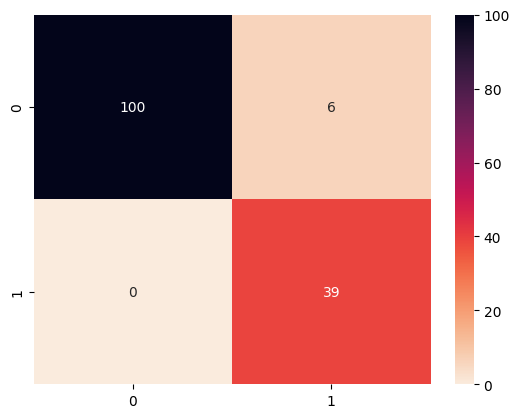

In [610]:
mc=confusion_matrix(y0_pred,y0_test)
mc_norm = mc / np.linalg.norm(mc, axis=1, keepdims=True)
sns.heatmap(pd.DataFrame(mc), cmap=sns.cm.rocket_r, annot=True, fmt='.5g');

In [611]:
cross_val_score(rf_classifier0,X0_train,y0_train,cv=3,scoring='precision').mean()

0.9606698019683108

In [612]:
cross_val_score(rf_classifier0,X0_train,y0_train,cv=3,scoring='recall').mean()

0.9277777777777777

In [613]:
cross_val_score(rf_classifier0,X0_train,y0_train,cv=3,scoring='f1').mean()

0.951303149865358

In [614]:
#Precision score
precision_score(y0_pred, y0_test)

0.8666666666666667

In [615]:
#Specificity score
specificity_score(y0_pred,y0_test)

0.9433962264150944

In [616]:
#ROC AUC score
roc_auc_score(y0_pred,y0_test)

0.9716981132075472

In [617]:
#Recall score
recall_score(y0_test, y0_pred) 

0.8666666666666667

In [618]:
#F1 score
f1_score(y0_test, y0_pred) 

0.9285714285714286

In [619]:
print(classification_report(y0_test,y0_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       100
           1       1.00      0.87      0.93        45

    accuracy                           0.96       145
   macro avg       0.97      0.93      0.95       145
weighted avg       0.96      0.96      0.96       145



In [620]:
#we go through all the subdirectories corresponding to each AGN and in each one all the files with different observations and we make a classification for each observation.

path = '/home/anakin/Documents/Tesis/Codigo/AGNs/' #path to main directory
filelist = os.listdir(path)
df_obs_err = []
names1 = []
observations = []
k=0
#Make empty list to store all paths to subdirectories in.
path2 = []
for x in filelist:
    if x.startswith('agn'):
        path2.append(path + x+ '/')

for i in path2:
    filelist2 = os.listdir(i)
    c=0
    p=0
    for j in filelist2:
        if j.endswith('.csv'):
            file = pd.read_csv(i+j, dtype=np.float64, na_values='INDEF')
            long= len(file['D1'])

            err_features_obs = []

            features_obs = dataframe_obs(file)[1]
            
            # Store the features 
            err_features_obs.append(features_obs)    
                
            # Convert lists to a DataFrame
            features_df_var = pd.DataFrame(err_features_obs)

            # Predict with the model
            predicted = rf_classifier0.predict(features_df_var)
    
            print(j, ':Classified', predicted, 'with', long, 'observations')

            c+=1
            if predicted == 1:
                
                df_obs_err.append(features_obs)
                names1.append(j)
                observations.append(long)

                p+=1
                
    prob = p/c*100

    print('-------------------------------------------------',names_agns[k], 'is variable whit a probability of:', prob, '%')
    k+=1

# Convert lists to a DataFrame
df_obs_err = pd.DataFrame(df_obs_err)
df_obs_err['AGN_n_obs'] = names1
df_obs_err['Observations'] = observations

1424R-140415.csv :Classified [0] with 9 observations
1424V-140415.csv :Classified [0] with 9 observations
------------------------------------------------- agn_1424 is variable whit a probability of: 0.0 %
0521V-111215.csv :Classified [0] with 21 observations
0521R-111215.csv :Classified [0] with 20 observations
------------------------------------------------- agn_0521 is variable whit a probability of: 0.0 %
1116R-130415.csv :Classified [0] with 15 observations
1116R-140415.csv :Classified [0] with 12 observations
1116V-130415.csv :Classified [1] with 15 observations
1116V-140415.csv :Classified [1] with 12 observations
------------------------------------------------- agn_1116 is variable whit a probability of: 50.0 %
1229V-120415.csv :Classified [0] with 13 observations
1229R-120415.csv :Classified [0] with 13 observations
------------------------------------------------- agn_1229 is variable whit a probability of: 0.0 %
1958V-230414.csv :Classified [0] with 11 observations
1958R-2

In [621]:
df_obs_err

,mag_w_e_mean,mag_w_e_var,mag_w_e_skew,mag_w_e_kurt,AGN_n_obs,Observations
0,0.112933,0.000857,0.050781,-1.129494,1116V-130415.csv,15
1,0.227833,0.001494,0.611344,-1.191094,1116V-140415.csv,12
2,0.855000,0.001063,0.065795,-1.326321,0208R-130815.csv,9
3,1.327667,0.002670,0.494768,-1.370405,0208V-150915.csv,6
4,0.685889,0.000977,-0.312898,-1.128564,0208V-130815.csv,9
5,0.687000,0.001165,0.488886,-1.020814,2149V-120815.csv,4


In [622]:
df_obs

,mag_mean,mag_var,mag_skew,mag_kurt,AGN_n_obs,Observations
0,0.040444,0.000665,0.501270,-0.884148,1424V-140415.csv,9
1,0.112933,0.000857,0.050781,-1.129494,1116V-130415.csv,15
2,0.227833,0.001494,0.611344,-1.191094,1116V-140415.csv,12
3,0.482750,0.003018,1.471751,1.302412,1510V-040419.csv,8
4,0.855000,0.001063,0.065795,-1.326321,0208R-130815.csv,9
5,1.327667,0.002670,0.494768,-1.370405,0208V-150915.csv,6
6,0.685889,0.000977,-0.312898,-1.128564,0208V-130815.csv,9
7,0.687000,0.001165,0.488886,-1.020814,2149V-120815.csv,4
8,0.678071,0.000681,0.542535,-0.866700,2155V-150915.csv,14


### Now we perform a model to classify periodics AGNs.

In [623]:
#Create an save the dataframe 

def dataframe1(df, N, p, star, err_star, c, x, a): # p is the value of the target variable. 1 for variable AGNs and 0 for non-viarable AGNs
                               # df and star must have the same subindex

    for i in range(N): # N: number of AGNs in the dataset
        p = 0
        agn_a = agns(df)[c]
        agn = agn_a[i]

        err_a = agns(df)[x]
        err_agn = err_a[i]

        #Calculates the calibrated magnitude of the AGN
        mag = calibration(agn, star, err_agn, err_star)[0]
        err_mag = calibration(agn, star, err_agn, err_star)[1]

        rng = np.random.default_rng()
        t = rng.uniform(0, 2, N)

        if t[i] <= 1:

            mag_w_err = mag + err_mag

        else:

            mag_w_err = mag - err_mag
        
        # Extract features from the time series data
        features = extract_features(mag, mag_w_err)
        
        # Store the features and the target variable
        data_features.append(features)

        if i == 3 and a == 3:

            p = 1
        
        if p == 1:
            
            Periodicity.append(1)
        else:
            
            Periodicity.append(0)

    return data_features

In [624]:
#First whit the non-periodic AGNs

data_features = []
Periodicity = []

for i in range(len(dff)):

    dt = dff[i]
    star = agns(dt)[2]
    err_star = agns(dt)[3]
    data_features = dataframe1(dt, 200, 0, star, err_star, 0, 1, 0)

    # Convert lists to a DataFrame
    features_df1 = pd.DataFrame(data_features)
    features_df1['Periodicity'] = Periodicity       

 # Save the DataFrame to a CSV file
#features_df.to_csv('simulated_time_series_data_agns.csv', index=False)

In [625]:
#Then with the periodics AGNs

for i in range(len(dff)):

    dt = dff[i]
    star = agns(dt)[2]
    err_star = agns(dt)[3]
    data_features = dataframe1(dt, 9, 0, star, err_star, 4, 5, 3)

    # Convert lists to a DataFrame
    features_df1 = pd.DataFrame(data_features)
    features_df1['Periodicity'] = Periodicity       


In [626]:
features_df1

,mag_mean,mag_var,mag_skew,mag_kurt,mag_w_e_mean,mag_w_e_var,mag_w_e_skew,mag_w_e_kurt,Periodicity
0,0.010450,0.000020,-0.233428,-0.543255,0.016450,0.000020,-0.233428,-0.543255,0
1,-0.014100,0.000017,-0.209839,0.418627,-0.008100,0.000017,-0.209839,0.418627,0
2,-0.009125,0.000016,0.335852,-0.078736,-0.003125,0.000016,0.335852,-0.078736,0
3,-0.004100,0.000017,-0.199723,-0.703788,-0.010100,0.000017,-0.199723,-0.703788,0
4,0.000325,0.000013,-0.097803,-0.743768,-0.005675,0.000013,-0.097803,-0.743768,0
...,...,...,...,...,...,...,...,...,...
5220,0.013825,0.006252,-0.131830,-1.091343,-0.002375,0.006280,-0.118861,-1.075591,0
5221,-0.012100,0.004425,-0.281331,-1.361673,-0.028300,0.004399,-0.264609,-1.367214,0
5222,0.011225,0.001518,-0.197547,0.424307,0.026825,0.001507,-0.204807,0.346040,0
5223,-0.015050,0.001099,-0.067906,-1.155384,0.000550,0.001114,-0.062016,-1.168911,0


In [627]:
features_df1.isna().sum()

mag_mean        0
mag_var         0
mag_skew        0
mag_kurt        0
mag_w_e_mean    0
mag_w_e_var     0
mag_w_e_skew    0
mag_w_e_kurt    0
Periodicity     0
dtype: int64

In [628]:
features_df1.fillna(0, inplace=True)
features_df1.dropna(inplace=True)

In [629]:
features_df1.corr()

,mag_mean,mag_var,mag_skew,mag_kurt,mag_w_e_mean,mag_w_e_var,mag_w_e_skew,mag_w_e_kurt,Periodicity
mag_mean,1.000000,-0.041650,0.026497,0.028460,0.910781,-0.039082,0.028845,0.023847,-0.036430
mag_var,-0.041650,1.000000,-0.059936,-0.158785,-0.030039,0.998985,-0.050287,-0.157935,0.075249
mag_skew,0.026497,-0.059936,1.000000,0.043838,0.020145,-0.062039,0.810011,0.045328,-0.094154
mag_kurt,0.028460,-0.158785,0.043838,1.000000,0.029342,-0.151845,0.040291,0.899463,-0.077549
mag_w_e_mean,0.910781,-0.030039,0.020145,0.029342,1.000000,-0.029199,0.175991,0.028064,-0.033614
mag_w_e_var,-0.039082,0.998985,-0.062039,-0.151845,-0.029199,1.000000,-0.052638,-0.151136,0.074458
mag_w_e_skew,0.028845,-0.050287,0.810011,0.040291,0.175991,-0.052638,1.000000,0.052770,-0.083796
mag_w_e_kurt,0.023847,-0.157935,0.045328,0.899463,0.028064,-0.151136,0.052770,1.000000,-0.076554
Periodicity,-0.036430,0.075249,-0.094154,-0.077549,-0.033614,0.074458,-0.083796,-0.076554,1.000000


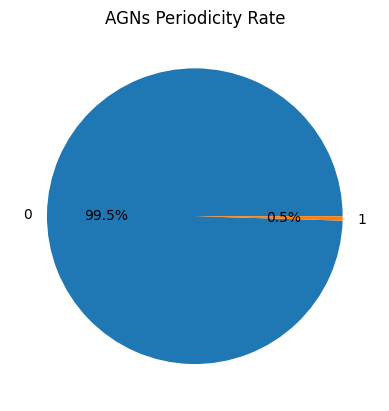

In [630]:
pie_x, pie_y = np.unique(features_df1['Periodicity'], return_counts=True)
plt.pie(pie_y, labels=pie_x, autopct = '%1.1f%%') 
plt.title('AGNs Periodicity Rate')
plt.show()

#### This dataset is very unbalanced.

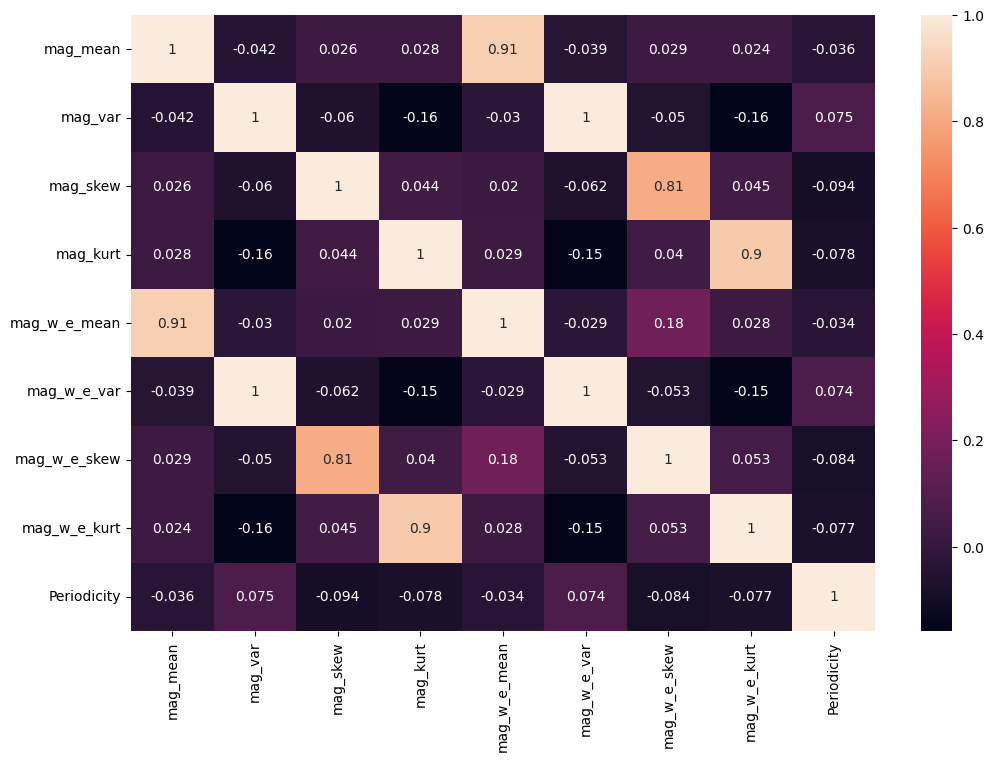

In [631]:
#Perform a correlation matrix to see how the data are related.

plt.figure(figsize=(12,8))
sns.heatmap(features_df1.corr(), annot=True)
plt.show()

In [632]:
features_df1['Periodicity'].value_counts()

Periodicity
0    5200
1      25
Name: count, dtype: int64

In [633]:
df_2 = features_df1[features_df1['Periodicity'] == 0 ].sample(n=100)

In [634]:
df_2

,mag_mean,mag_var,mag_skew,mag_kurt,mag_w_e_mean,mag_w_e_var,mag_w_e_skew,mag_w_e_kurt,Periodicity
1170,-0.010900,0.000033,0.206836,-0.428178,-0.000900,0.000033,0.206836,-0.428178,0
2592,0.102250,0.000119,0.670614,0.905965,0.114975,0.000126,0.687224,0.869170,0
1510,-0.007825,0.000045,0.226758,0.330818,0.000175,0.000045,0.226758,0.330818,0
613,-0.013800,0.000014,0.604443,0.303549,-0.019800,0.000014,0.604443,0.303549,0
3144,0.014225,0.000206,-0.092373,-0.489003,0.032625,0.000206,-0.090057,-0.504404,0
...,...,...,...,...,...,...,...,...,...
605,0.003875,0.000023,-0.429056,-0.232637,-0.002125,0.000023,-0.429056,-0.232637,0
4164,-0.008650,0.000466,-0.086389,-0.610830,-0.039875,0.000553,-0.309361,-0.686847,0
983,0.054875,0.000063,0.273502,-0.488964,0.044575,0.000063,0.315764,-0.410133,0
4245,-0.004425,0.000160,-0.900124,1.943166,-0.022225,0.000221,-1.363658,2.406669,0


In [635]:
df_3 = features_df1[features_df1['Periodicity'] == 1 ].sample(n=25)

In [636]:
df_3

,mag_mean,mag_var,mag_skew,mag_kurt,mag_w_e_mean,mag_w_e_var,mag_w_e_skew,mag_w_e_kurt,Periodicity
5012,-0.006400,0.000968,-0.691676,-0.863887,-0.000400,0.000968,-0.691676,-0.863887,1
5210,-0.007550,0.001131,-0.390459,-1.005621,-0.022950,0.001055,-0.392406,-1.080180,1
5201,-0.008150,0.000838,-0.465929,-1.004655,-0.022875,0.000847,-0.426608,-1.057327,1
5057,-0.006400,0.000968,-0.691676,-0.863887,-0.000400,0.000968,-0.691676,-0.863887,1
5021,-0.005300,0.000946,-0.543974,-1.099840,0.000700,0.000946,-0.543974,-1.099840,1
5093,-0.005050,0.001052,-0.683573,-0.919287,0.003325,0.001031,-0.686291,-0.953607,1
5003,-0.006975,0.000952,-0.602181,-0.987928,-0.012975,0.000952,-0.602181,-0.987928,1
5084,-0.006150,0.001005,-0.495720,-1.087437,-0.012200,0.001001,-0.500716,-1.087095,1
5138,-0.005225,0.001031,-0.501628,-0.989570,-0.016875,0.001012,-0.500548,-0.989853,1
5111,-0.005625,0.000902,-0.611688,-1.025145,0.002300,0.000911,-0.623331,-0.996666,1


In [637]:
dfn = pd.concat([df_2, df_3])

In [638]:
dfn.index =  range(dfn.shape[0])

In [639]:
dfn

,mag_mean,mag_var,mag_skew,mag_kurt,mag_w_e_mean,mag_w_e_var,mag_w_e_skew,mag_w_e_kurt,Periodicity
0,-0.010900,0.000033,0.206836,-0.428178,-0.000900,0.000033,0.206836,-0.428178,0
1,0.102250,0.000119,0.670614,0.905965,0.114975,0.000126,0.687224,0.869170,0
2,-0.007825,0.000045,0.226758,0.330818,0.000175,0.000045,0.226758,0.330818,0
3,-0.013800,0.000014,0.604443,0.303549,-0.019800,0.000014,0.604443,0.303549,0
4,0.014225,0.000206,-0.092373,-0.489003,0.032625,0.000206,-0.090057,-0.504404,0
...,...,...,...,...,...,...,...,...,...
120,-0.005725,0.000933,-0.573242,-1.038245,0.001450,0.000973,-0.513757,-1.053956,1
121,-0.005125,0.001102,-0.716371,-0.397814,0.008225,0.001048,-0.726787,-0.431989,1
122,-0.006975,0.000926,-0.586095,-1.092472,-0.000175,0.000926,-0.578856,-1.138051,1
123,-0.008400,0.001223,-0.567844,-0.886027,-0.024750,0.001452,-0.538448,-0.874752,1


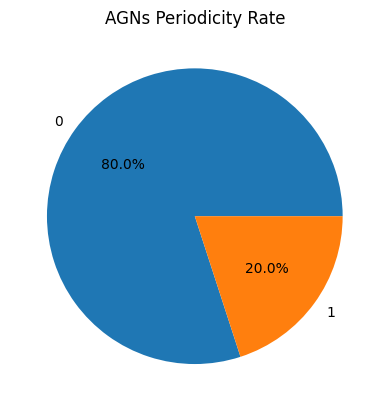

In [640]:
pie_x, pie_y = np.unique(dfn['Periodicity'], return_counts=True)
plt.pie(pie_y, labels=pie_x, autopct = '%1.1f%%') 
plt.title('AGNs Periodicity Rate')
plt.show()

### Machine Learining Models

In [641]:
#Apply a Random Forest classifier with the original dataset.

data2 = features_df1.copy()

# Split the data into features and target
X = data2.drop('Periodicity', axis=1)[['mag_mean', 'mag_var', 'mag_skew', 'mag_kurt']]
y = data2['Periodicity']

# Split the dataset into training and testing sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y, test_size=0.3, random_state=20, stratify = y)

# Initialize the Random Forest Classifier
rf_classifier2 = RandomForestClassifier(max_depth=3)

# Train the model
rf_classifier2.fit(X2_train, y2_train)

# Make predictions on the test set
y2_pred = rf_classifier2.predict(X2_test)

# Evaluate the model
accuracy_score(y2_pred,y2_test)

0.9974489795918368

In [642]:
#Another Machine Learning model, a Random Forest classifier with an undersampling.

# Split the data into features and target
X = dfn.drop('Periodicity', axis=1)[['mag_mean', 'mag_var', 'mag_skew', 'mag_kurt']]
y = dfn['Periodicity']

# Split the dataset into training and testing sets
X3_train, X3_test, y3_train, y3_test = train_test_split(X, y, test_size=0.2, random_state=20, stratify = y)

# Initialize the Random Forest Classifier
rf_classifier3 = RandomForestClassifier(max_depth=3)

# Train the model
rf_classifier3.fit(X3_train, y3_train)

# Make predictions on the test set
y3_pred = rf_classifier3.predict(X3_test)

# Evaluate the model
accuracy_score(y3_pred,y3_test)

1.0

In [643]:
#Another Machine Learning model, a Random Forest classifier with an OverSampling.

data = features_df1.copy()

# Split the data into features and target
X = data.drop('Periodicity', axis=1)[['mag_mean', 'mag_var', 'mag_skew', 'mag_kurt']]
y = data['Periodicity']

ros = RandomOverSampler(random_state=20, sampling_strategy='minority')

X_res, y_res = ros.fit_resample(X, y)

# Split the dataset into training and testing sets
X4_train, X4_test, y4_train, y4_test = train_test_split(X_res, y_res, test_size=0.3, random_state=20, stratify = y_res)

# Initialize the Random Forest Classifier
rf_classifier4 = RandomForestClassifier(max_depth=3)

# Train the model
rf_classifier4.fit(X4_train, y4_train)

# Make predictions on the test set
y4_pred = rf_classifier4.predict(X4_test)

# Evaluate the model
accuracy_score(y4_pred,y4_test)

0.9996794871794872

#### We use the metrics to evaluate the model

Metrics for the first model

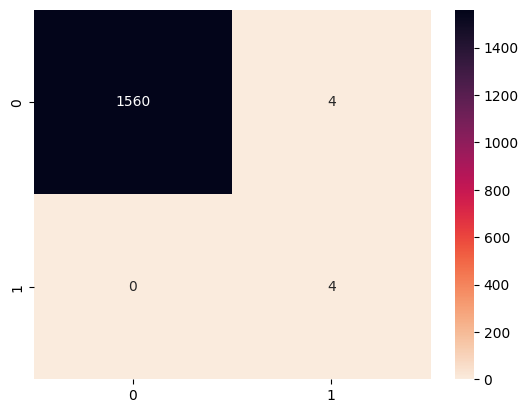

In [644]:
mc=confusion_matrix(y2_pred,y2_test)
mc_norm = mc / np.linalg.norm(mc, axis=1, keepdims=True)
sns.heatmap(pd.DataFrame(mc), cmap=sns.cm.rocket_r, annot=True, fmt='.5g');

In [645]:
cross_val_score(rf_classifier2,X2_train,y2_train,cv=3,scoring='precision').mean()

1.0

In [646]:
cross_val_score(rf_classifier2,X2_train,y2_train,cv=3,scoring='recall').mean()

0.8333333333333334

In [647]:
cross_val_score(rf_classifier2,X2_train,y2_train,cv=3,scoring='f1').mean()

0.903030303030303

Metrics of second Random Forest Model

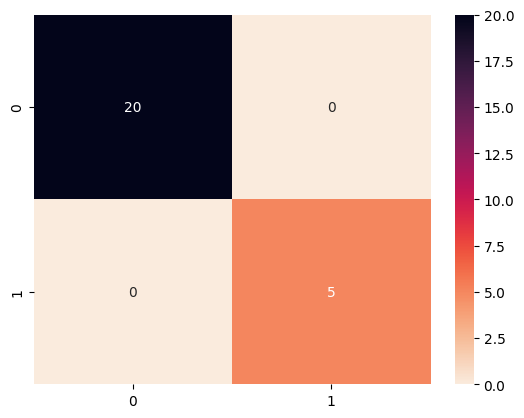

In [648]:
mc=confusion_matrix(y3_pred,y3_test)
mc_norm = mc / np.linalg.norm(mc, axis=1, keepdims=True)
sns.heatmap(pd.DataFrame(mc), cmap=sns.cm.rocket_r, annot=True, fmt='.5g');

In [649]:
cross_val_score(rf_classifier3,X3_train,y3_train,cv=3,scoring='precision').mean()

0.8842592592592592

In [650]:
cross_val_score(rf_classifier3,X3_train,y3_train,cv=3,scoring='recall').mean()

1.0

In [651]:
cross_val_score(rf_classifier3,X3_train,y3_train,cv=3,scoring='f1').mean()

0.9583333333333334

Metrics of the last Model

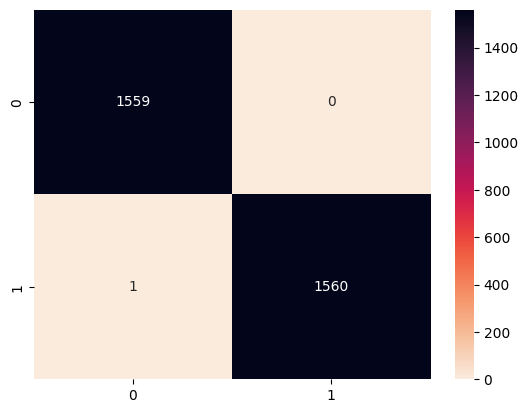

In [652]:
mc=confusion_matrix(y4_pred,y4_test)
mc_norm = mc / np.linalg.norm(mc, axis=1, keepdims=True)
sns.heatmap(pd.DataFrame(mc), cmap=sns.cm.rocket_r, annot=True, fmt='.5g');

In [653]:
cross_val_score(rf_classifier4,X4_train,y4_train,cv=3,scoring='precision').mean()

0.9986291584937349

In [654]:
cross_val_score(rf_classifier4,X4_train,y4_train,cv=3,scoring='recall').mean()

1.0

In [655]:
cross_val_score(rf_classifier4,X4_train,y4_train,cv=3,scoring='f1').mean()

0.9995886466474703

#### We'll try with one more model, whit an OverSampling in the undersampled dataset

In [656]:
#Another Machine Learning model, a Random Forest classifier with an undersampling.

# Split the data into features and target
X = dfn.drop('Periodicity', axis=1)[['mag_mean', 'mag_var', 'mag_skew', 'mag_kurt']]
y = dfn['Periodicity']

ros = RandomOverSampler(random_state=20, sampling_strategy='minority')

X_res, y_res = ros.fit_resample(X, y)

# Split the dataset into training and testing sets
X5_train, X5_test, y5_train, y5_test = train_test_split(X_res, y_res, test_size=0.2, random_state=20, stratify = y_res)

# Initialize the Random Forest Classifier
rf_classifier5 = RandomForestClassifier(max_depth=10)

# Train the model
rf_classifier5.fit(X5_train, y5_train)

# Make predictions on the test set
y5_pred = rf_classifier5.predict(X5_test)

# Evaluate the model
accuracy_score(y5_pred,y5_test)

1.0

Calculate the metrics

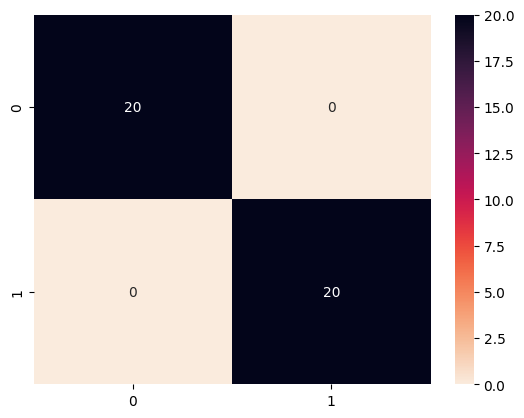

In [657]:
mc=confusion_matrix(y5_pred,y5_test)
mc_norm = mc / np.linalg.norm(mc, axis=1, keepdims=True)
sns.heatmap(pd.DataFrame(mc), cmap=sns.cm.rocket_r, annot=True, fmt='.5g');

In [658]:
cross_val_score(rf_classifier5,X5_train,y5_train,cv=3,scoring='precision').mean()

0.9757495590828924

In [659]:
cross_val_score(rf_classifier5,X5_train,y5_train,cv=3,scoring='recall').mean()

1.0

In [660]:
cross_val_score(rf_classifier5,X5_train,y5_train,cv=3,scoring='f1').mean()

0.9876500857632933

#### Let's try with one last model, using only the variable AGNs for the training set.

In [661]:
data_features = []
Periodicity = []

for i in range(len(dff)):

    dt = dff[i]
    star = agns(dt)[2]
    err_star = agns(dt)[3]
    data_features = dataframe1(dt, 9, 0, star, err_star, 4, 5, 3)

    # Convert lists to a DataFrame
    features_df2 = pd.DataFrame(data_features)
    features_df2['Periodicity'] = Periodicity  

In [662]:
features_df2

,mag_mean,mag_var,mag_skew,mag_kurt,mag_w_e_mean,mag_w_e_var,mag_w_e_skew,mag_w_e_kurt,Periodicity
0,-0.011750,0.003535,0.088334,-1.175707,-0.005750,0.003535,0.088334,-1.175707,0
1,-0.011600,0.003450,0.054997,-1.173883,-0.005600,0.003450,0.054997,-1.173883,0
2,-0.006625,0.002225,-0.906979,-0.527377,-0.000625,0.002225,-0.906979,-0.527377,0
3,-0.006975,0.000952,-0.602181,-0.987928,-0.012975,0.000952,-0.602181,-0.987928,1
4,0.007700,0.007092,-0.257085,-1.003337,0.000625,0.007092,-0.256923,-1.005875,0
...,...,...,...,...,...,...,...,...,...
220,0.013825,0.006252,-0.131830,-1.091343,0.030025,0.006243,-0.145639,-1.101369,0
221,-0.012100,0.004425,-0.281331,-1.361673,0.004100,0.004470,-0.292878,-1.350930,0
222,0.011225,0.001518,-0.197547,0.424307,0.026825,0.001507,-0.204807,0.346040,0
223,-0.015050,0.001099,-0.067906,-1.155384,0.000550,0.001114,-0.062016,-1.168911,0


In [663]:
features_df2['Periodicity'].value_counts()

Periodicity
0    200
1     25
Name: count, dtype: int64

In [664]:
#Another Machine Learning model, a Random Forest classifier with an OverSampling.

data = features_df2.copy()

# Split the data into features and target
X = data.drop('Periodicity', axis=1)[['mag_mean', 'mag_var', 'mag_skew', 'mag_kurt']]
y = data['Periodicity']

ros = RandomOverSampler(random_state=20, sampling_strategy='minority')

X_res, y_res = ros.fit_resample(X, y)

# Split the dataset into training and testing sets
X6_train, X6_test, y6_train, y6_test = train_test_split(X_res, y_res, test_size=0.2, random_state=20, stratify = y_res)

# Initialize the Random Forest Classifier
rf_classifier6 = RandomForestClassifier(max_depth=3)

# Train the model
rf_classifier6.fit(X6_train, y6_train)

# Make predictions on the test set
y6_pred = rf_classifier6.predict(X6_test)

# Evaluate the model
accuracy_score(y6_pred,y6_test)

0.9875

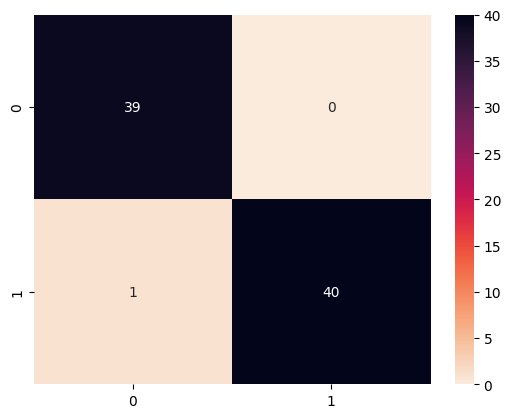

In [665]:
mc=confusion_matrix(y6_pred,y6_test)
mc_norm = mc / np.linalg.norm(mc, axis=1, keepdims=True)
sns.heatmap(pd.DataFrame(mc), cmap=sns.cm.rocket_r, annot=True, fmt='.5g');

In [666]:
cross_val_score(rf_classifier6,X6_train,y6_train,cv=3,scoring='precision').mean()

0.9821428571428571

In [667]:
cross_val_score(rf_classifier6,X6_train,y6_train,cv=3,scoring='recall').mean()

1.0

In [668]:
cross_val_score(rf_classifier6,X6_train,y6_train,cv=3,scoring='f1').mean()

0.9878787878787879

In [669]:
#Precision score
precision_score(y6_pred, y6_test)

1.0

In [670]:
#ROC AUC score
roc_auc_score(y6_pred,y6_test)

0.9878048780487805

In [671]:
#Recall score
recall_score(y6_test, y6_pred) 

1.0

In [672]:
#F1 score
f1_score(y6_test, y6_pred) 

0.9876543209876543

In [673]:
print(classification_report(y6_test,y6_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        40
           1       0.98      1.00      0.99        40

    accuracy                           0.99        80
   macro avg       0.99      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80



#### Let's try an other classifier model, an XGBoost.

In [709]:
# Scaling the data
from sklearn.preprocessing import MinMaxScaler

data = features_df2.copy()

# Split the data into features and target
X = data.drop('Periodicity', axis=1)[['mag_mean', 'mag_var', 'mag_skew', 'mag_kurt']]
y = data['Periodicity']

ros = RandomOverSampler(random_state=20, sampling_strategy='minority')

X_res, y_res = ros.fit_resample(X, y)

# Split the dataset into training and testing sets
Xg_train, Xg_test, yg_train, yg_test = train_test_split(X_res, y_res, test_size=0.2, random_state=20, stratify = y_res)

X_scaler, y_scaler = MinMaxScaler(), MinMaxScaler()

# Fitting the scalers and transforming the training sets
Xg_train = X_scaler.fit_transform(Xg_train)
yg_train = y_scaler.fit_transform((yg_train).to_numpy().reshape(-1,1))

# Transforming the test set
Xg_test = X_scaler.transform(Xg_test)
#yg_test = y_scaler.transform((yg_test).to_numpy().reshape(-1,1))

In [712]:
#XGBoost

xgbr = xgb.XGBRegressor(n_estimators=500)

# Fitting XGBoost
xgbr.fit(Xg_train, yg_train)

# Predicting for the test set
yg_pred = xgbr.predict(Xg_test)
yg_pred = y_scaler.inverse_transform(yg_pred.reshape(-1,1))

In [713]:
# Metrics of the XGBoost prediction

#from sklearn.metrics import mean_squared_error, r2_score
score_xgb = r2_score(yg_test, yg_pred)
std_xgb = np.sqrt(mean_squared_error(yg_test, yg_pred))
print("The R2 was:", score_xgb)
print("The RMSE was:", std_xgb)

The R2 was: 0.9968539370165822
The RMSE was: 0.02804488805209332


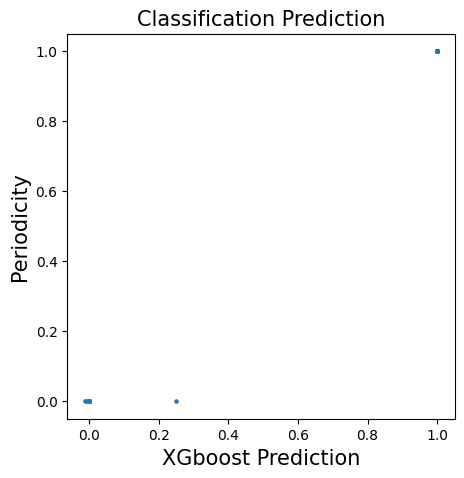

In [716]:
# Plotting the predict
plt.figure(figsize=(5,5))
plt.scatter(yg_pred, yg_test, s=5)
plt.title("Classification Prediction", fontsize=15)
plt.xlabel("XGboost Prediction", fontsize=15)
plt.ylabel("Periodicity", fontsize=15)
plt.show()

#### Predict with the model XGBoost model

In [674]:
df_obs

,mag_mean,mag_var,mag_skew,mag_kurt,AGN_n_obs,Observations
0,0.040444,0.000665,0.501270,-0.884148,1424V-140415.csv,9
1,0.112933,0.000857,0.050781,-1.129494,1116V-130415.csv,15
2,0.227833,0.001494,0.611344,-1.191094,1116V-140415.csv,12
3,0.482750,0.003018,1.471751,1.302412,1510V-040419.csv,8
4,0.855000,0.001063,0.065795,-1.326321,0208R-130815.csv,9
5,1.327667,0.002670,0.494768,-1.370405,0208V-150915.csv,6
6,0.685889,0.000977,-0.312898,-1.128564,0208V-130815.csv,9
7,0.687000,0.001165,0.488886,-1.020814,2149V-120815.csv,4
8,0.678071,0.000681,0.542535,-0.866700,2155V-150915.csv,14


In [675]:
name_agn = df_obs['AGN_n_obs']

obs = df_obs['Observations']

In [717]:
#Predict whit the model using the variables AGNs classified before.

df_obs_copy = df_obs.drop(['AGN_n_obs', 'Observations'], axis=1)

for i in range(len(df_obs)):

    
    predicted_per = xgbr.predict(np.array(df_obs_copy.loc[i]).reshape(1,-1))

    print(name_agn[i], ':Classified', predicted, 'with', obs[i], 'observations');


1424V-140415.csv :Classified [0] with 9 observations
1116V-130415.csv :Classified [0] with 15 observations
1116V-140415.csv :Classified [0] with 12 observations
1510V-040419.csv :Classified [0] with 8 observations
0208R-130815.csv :Classified [0] with 9 observations
0208V-150915.csv :Classified [0] with 6 observations
0208V-130815.csv :Classified [0] with 9 observations
2149V-120815.csv :Classified [0] with 4 observations
2155V-150915.csv :Classified [0] with 14 observations


In [719]:
#we go through all the subdirectories corresponding to each AGN and in each one all the files with different observations and we make a classification for each observation.

path = '/home/anakin/Documents/Tesis/Codigo/AGNs/' #path to main directory
filelist = os.listdir(path)
df_obs_p = []
names1 = []
k=0
#Make empty list to store all paths to subdirectories in.
path2 = []
for x in filelist:
    if x.startswith('agn'):
        path2.append(path + x+ '/')

for i in path2:
    filelist2 = os.listdir(i)
    c=0
    p=0
    for j in filelist2:
        if j.endswith('.csv'):
            file = pd.read_csv(i+j, dtype=np.float64, na_values='INDEF')
            long= len(file['D1'])

            data_features_obs = []

            features_obs = dataframe_obs(file)[0]

            # Store the features 
            data_features_obs.append(features_obs) 
                
            # Convert lists to a DataFrame
            features_df_per = pd.DataFrame(data_features_obs)

            # Predict with the model
            predicted_per = xgbr.predict(features_df_per)
    
            print(j, ':Classified', predicted, 'with', long, 'observations')

            c+=1
            if predicted == 1:
                
                df_obs_p.append(features_obs)
                names1.append(j)

                p+=1
                
    prob = p/c*100

    print('-------------------------------------------------',names_agns[k], 'is Periodic whit a probability of:', prob, '%')
    k+=1

# Convert lists to a DataFrame
df_obs_p = pd.DataFrame(df_obs_p)
df_obs_p['AGN_n_obs'] = names1

 # Save the DataFrame to a CSV file
df_obs_p.to_csv('observations_AGNs.csv', index=False)

1424R-140415.csv :Classified [0] with 9 observations
1424V-140415.csv :Classified [0] with 9 observations
------------------------------------------------- agn_1424 is Periodic whit a probability of: 0.0 %
0521V-111215.csv :Classified [0] with 21 observations
0521R-111215.csv :Classified [0] with 20 observations
------------------------------------------------- agn_0521 is Periodic whit a probability of: 0.0 %
1116R-130415.csv :Classified [0] with 15 observations
1116R-140415.csv :Classified [0] with 12 observations
1116V-130415.csv :Classified [0] with 15 observations
1116V-140415.csv :Classified [0] with 12 observations
------------------------------------------------- agn_1116 is Periodic whit a probability of: 0.0 %
1229V-120415.csv :Classified [0] with 13 observations
1229R-120415.csv :Classified [0] with 13 observations
------------------------------------------------- agn_1229 is Periodic whit a probability of: 0.0 %
1958V-230414.csv :Classified [0] with 11 observations
1958R-24

#### Predict with the model Random Forest model

In [718]:
#Predict whit the model using the variables AGNs classified before.

warnings.filterwarnings("ignore")

df_obs_copy = df_obs.drop(['AGN_n_obs', 'Observations'], axis=1)

for i in range(len(df_obs)):

    
    predicted_per = rf_classifier6.predict(np.array(df_obs_copy.loc[i]).reshape(1,-1))

    print(name_agn[i], ':Classified', predicted, 'with', obs[i], 'observations');

    

1424V-140415.csv :Classified [0] with 9 observations
1116V-130415.csv :Classified [0] with 15 observations
1116V-140415.csv :Classified [0] with 12 observations
1510V-040419.csv :Classified [0] with 8 observations
0208R-130815.csv :Classified [0] with 9 observations
0208V-150915.csv :Classified [0] with 6 observations
0208V-130815.csv :Classified [0] with 9 observations
2149V-120815.csv :Classified [0] with 4 observations
2155V-150915.csv :Classified [0] with 14 observations


In [677]:
#we go through all the subdirectories corresponding to each AGN and in each one all the files with different observations and we make a classification for each observation.

path = '/home/anakin/Documents/Tesis/Codigo/AGNs/' #path to main directory
filelist = os.listdir(path)
df_obs_p = []
names1 = []
k=0
#Make empty list to store all paths to subdirectories in.
path2 = []
for x in filelist:
    if x.startswith('agn'):
        path2.append(path + x+ '/')

for i in path2:
    filelist2 = os.listdir(i)
    c=0
    p=0
    for j in filelist2:
        if j.endswith('.csv'):
            file = pd.read_csv(i+j, dtype=np.float64, na_values='INDEF')
            long= len(file['D1'])

            data_features_obs = []

            features_obs = dataframe_obs(file)[0]

            # Store the features 
            data_features_obs.append(features_obs) 
                
            # Convert lists to a DataFrame
            features_df_per = pd.DataFrame(data_features_obs)

            # Predict with the model
            predicted_per = rf_classifier6.predict(features_df_per)
    
            print(j, ':Classified', predicted, 'with', long, 'observations')

            c+=1
            if predicted == 1:
                
                df_obs_p.append(features_obs)
                names1.append(j)

                p+=1
                
    prob = p/c*100

    print('-------------------------------------------------',names_agns[k], 'is Periodic whit a probability of:', prob, '%')
    k+=1

# Convert lists to a DataFrame
df_obs_p = pd.DataFrame(df_obs_p)
df_obs_p['AGN_n_obs'] = names1

 # Save the DataFrame to a CSV file
df_obs_p.to_csv('observations_AGNs.csv', index=False)

1424R-140415.csv :Classified [0] with 9 observations
1424V-140415.csv :Classified [0] with 9 observations
------------------------------------------------- agn_1424 is Periodic whit a probability of: 0.0 %
0521V-111215.csv :Classified [0] with 21 observations
0521R-111215.csv :Classified [0] with 20 observations
------------------------------------------------- agn_0521 is Periodic whit a probability of: 0.0 %
1116R-130415.csv :Classified [0] with 15 observations
1116R-140415.csv :Classified [0] with 12 observations
1116V-130415.csv :Classified [0] with 15 observations
1116V-140415.csv :Classified [0] with 12 observations
------------------------------------------------- agn_1116 is Periodic whit a probability of: 0.0 %
1229V-120415.csv :Classified [0] with 13 observations
1229R-120415.csv :Classified [0] with 13 observations
------------------------------------------------- agn_1229 is Periodic whit a probability of: 0.0 %
1958V-230414.csv :Classified [0] with 11 observations
1958R-24

In [678]:
df_obs_p

,AGN_n_obs


#### One more time, we'll create another model using the magnitudes with erros variables. We do this to verify if the observationals errors are sufficiently significant to change our predictions.

In [679]:
#Another Machine Learning model, a Random Forest classifier with an OverSampling.

data = features_df2.copy()

# Split the data into features and target
X = data.drop('Periodicity', axis=1)[['mag_w_e_mean', 'mag_w_e_var', 'mag_w_e_skew', 'mag_w_e_kurt']]
y = data['Periodicity']

ros = RandomOverSampler(random_state=20, sampling_strategy='minority')

X_res, y_res = ros.fit_resample(X, y)

# Split the dataset into training and testing sets
X00_train, X00_test, y00_train, y00_test = train_test_split(X_res, y_res, test_size=0.2, random_state=20, stratify = y_res)

# Initialize the Random Forest Classifier
rf_classifier00 = RandomForestClassifier(max_depth=3)

# Train the model
rf_classifier00.fit(X00_train, y00_train)

# Make predictions on the test set
y00_pred = rf_classifier00.predict(X00_test)

# Evaluate the model
accuracy_score(y00_pred,y00_test)

0.9875

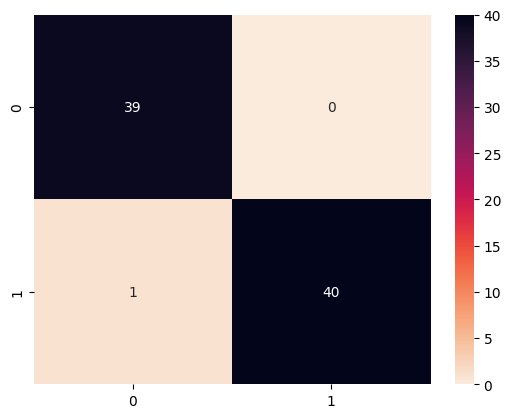

In [680]:
mc=confusion_matrix(y00_pred,y00_test)
mc_norm = mc / np.linalg.norm(mc, axis=1, keepdims=True)
sns.heatmap(pd.DataFrame(mc), cmap=sns.cm.rocket_r, annot=True, fmt='.5g');

In [681]:
cross_val_score(rf_classifier00,X00_train,y00_train,cv=3,scoring='precision').mean()

0.9705475810738968

In [682]:
cross_val_score(rf_classifier00,X00_train,y00_train,cv=3,scoring='recall').mean()

1.0

In [683]:
cross_val_score(rf_classifier00,X00_train,y00_train,cv=3,scoring='f1').mean()

0.984984984984985

In [684]:
#Precision score
precision_score(y00_pred, y00_test)

1.0

In [685]:
#ROC AUC score
roc_auc_score(y00_pred,y00_test)

0.9878048780487805

In [686]:
#Recall score
recall_score(y00_test, y00_pred) 

1.0

In [687]:
#F1 score
f1_score(y00_test, y00_pred) 

0.9876543209876543

In [688]:
print(classification_report(y00_test,y00_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        40
           1       0.98      1.00      0.99        40

    accuracy                           0.99        80
   macro avg       0.99      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80



In [689]:
#we go through all the subdirectories corresponding to each AGN and in each one all the files with different observations and we make a classification for each observation.

path = '/home/anakin/Documents/Tesis/Codigo/AGNs/' #path to main directory
filelist = os.listdir(path)
df_obs_p_err = []
names1 = []
k=0
#Make empty list to store all paths to subdirectories in.
path2 = []
for x in filelist:
    if x.startswith('agn'):
        path2.append(path + x+ '/')

for i in path2:
    filelist2 = os.listdir(i)
    c=0
    p=0
    for j in filelist2:
        if j.endswith('.csv'):
            file = pd.read_csv(i+j, dtype=np.float64, na_values='INDEF')
            long= len(file['D1'])

            data_features_obs = []

            features_obs = dataframe_obs(file)[1]

            # Store the features 
            data_features_obs.append(features_obs) 
                
            # Convert lists to a DataFrame
            features_df_per = pd.DataFrame(data_features_obs)

            # Predict with the model
            predicted_per = rf_classifier00.predict(features_df_per)
    
            print(j, ':Classified', predicted, 'with', long, 'observations')

            c+=1
            if predicted == 1:
                
                df_obs_p_err.append(features_obs)
                names1.append(j)

                p+=1
                
    prob = p/c*100

    print('-------------------------------------------------',names_agns[k], 'is Periodic whit a probability of:', prob, '%')
    k+=1

# Convert lists to a DataFrame
df_obs_p_err = pd.DataFrame(df_obs_p_err)
df_obs_p_err['AGN_n_obs'] = names1

 # Save the DataFrame to a CSV file
df_obs_p_err.to_csv('observations_AGNs.csv', index=False)

1424R-140415.csv :Classified [0] with 9 observations
1424V-140415.csv :Classified [0] with 9 observations
------------------------------------------------- agn_1424 is Periodic whit a probability of: 0.0 %
0521V-111215.csv :Classified [0] with 21 observations
0521R-111215.csv :Classified [0] with 20 observations
------------------------------------------------- agn_0521 is Periodic whit a probability of: 0.0 %
1116R-130415.csv :Classified [0] with 15 observations
1116R-140415.csv :Classified [0] with 12 observations
1116V-130415.csv :Classified [0] with 15 observations
1116V-140415.csv :Classified [0] with 12 observations
------------------------------------------------- agn_1116 is Periodic whit a probability of: 0.0 %
1229V-120415.csv :Classified [0] with 13 observations
1229R-120415.csv :Classified [0] with 13 observations
------------------------------------------------- agn_1229 is Periodic whit a probability of: 0.0 %
1958V-230414.csv :Classified [0] with 11 observations
1958R-24

In [690]:
df_obs_p

,AGN_n_obs


In [691]:
df_obs_p_err

,AGN_n_obs
